# Conditional Generative Adversarial Network (cGAN)
Let's code a cDCGAN on MNIST. We will need to condition the training of the GAN over the MNIST labels.

![alt text](https://machinelearningmastery.com/wp-content/uploads/2019/05/Example-of-a-Conditional-Generator-and-a-Conditional-Discriminator-in-a-Conditional-Generative-Adversarial-Network-1024x887.png)

In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

C:\miniconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Random Seed:  999


In [2]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32 # we use 32 instead of original mnist size (28) for simplicity

# Number of channels in the training images.
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# size of labels
label_dim = 10

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

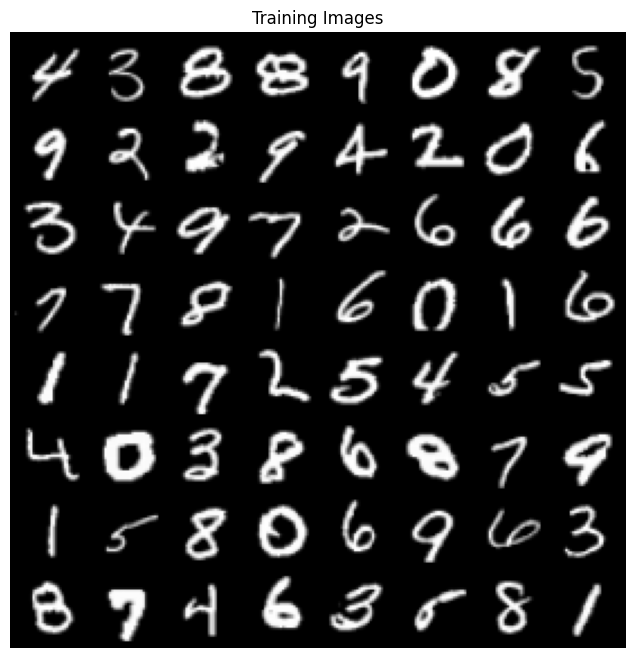

In [3]:
# MNIST dataset
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

mnist_data = dset.MNIST(root='./data',
                         train=True,
                         transform=transform,
                         download=True)

dataloader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=batch_size,
                                          shuffle=True)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Weights Initialization
From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02.

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.noise_block = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False), # bs, 100, 1, 1 -> bs, ngf * 2, 4, 4
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True)
         )
        
        self.label_block = nn.Sequential(
            # input are labels, going into a convolution
            nn.ConvTranspose2d(label_dim, ngf, 4, 1, 0, bias=False), #bs, 10, 1, 1 -> bs, ngf * 2, 4, 4
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, ngf, 4, 2, 1, bias=False), #bs, ngf*2, 4, 4 -> bs, ngf, 8, 8
            nn.BatchNorm2d(ngf),
            nn.ReLU(True)
         )
        
        self.main1 = nn.Sequential(
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d( ngf * 4, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True)
        )
        self.main2 = nn.Sequential(
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True)
        )
        self.main3 = nn.Sequential(
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )

    def forward(self, noise, labels):
        # first lets pass the noise and the labels...
        # through the corresponding layers
        z_out = self.noise_block(noise)
        l_out = self.label_block(labels)
        # bs, ngf*4, 4, 4
        x = self.main1(z_out)
        x = torch.cat([x, l_out], dim = 1) # concatenation over channels
        x = self.main2(x)
        return self.main3(x)

In [6]:
# Create the generator
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (noise_block): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (label_block): Sequential(
    (0): ConvTranspose2d(10, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (main1): Sequential(
    (0): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (main2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4,

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.img_block = nn.Sequential(        
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf//2, 4, 2, 1, bias=False), # bs, 1, 32, 32 -> bs, ndf//2, 16, 16
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.label_block = nn.Sequential(        # bs, 10, 32, 32 -> bs, ndf//2, 16, 16
            # input is (nc) x 32 x 32
            nn.Conv2d(label_dim, ndf//2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )        
        self.main = nn.Sequential(
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4 <---
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # state size. 1 x 1 x 1
        )

    def forward(self, img, label):
        # same steps as in generator but with images and labels
        img_out = self.img_block(img)
        lab_out = self.label_block(label)
        x = torch.cat([img_out, lab_out], dim = 1)
        return self.main(x)

In [8]:
# Create the Discriminator
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (img_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (label_block): Sequential(
    (0): Conv2d(10, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (main): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (7): Sigmoid()
  )
)


In [9]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(8, nz, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [10]:
# label preprocessing
# for the generator we will use onehot vectors
# for the discriminator we need onehot "images"
onehot = torch.zeros(label_dim, label_dim)

onehot = onehot.scatter_(1, torch.LongTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).view(label_dim, 1), 1)
onehot = onehot.view(label_dim, label_dim, 1, 1)

fill = torch.zeros([label_dim, label_dim, image_size, image_size])
for i in range(label_dim):
    fill[i, i, :, :] = 1

In [11]:
# function to generate test sample
def generate_test(fixed_noise, onehot, G):
    G.eval()
    # label 0
    c = (torch.ones(8)*0).type(torch.LongTensor) #[0,0,0,0,0,0,0,0]
    c_onehot = onehot[c].to(device)
    out = G(fixed_noise, c_onehot)
    inference_res = out

    # labels 1-9    
    for l in range(1,label_dim):
        c = (torch.ones(8)*l).type(torch.LongTensor)
        c_onehot = onehot[c].to(device)
        out = G(fixed_noise, c_onehot)
        inference_res = torch.cat([inference_res, out], dim = 0)
    G.train()
    return inference_res

In [12]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (imgs, labels) in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        b_size = imgs.size(0)
        
        # Establish convention for real and fake labels during training
        # Let's do it more simply than last time
        real_label = torch.ones(b_size).to(device)
        fake_label = torch.zeros(b_size).to(device)
        
        # Format batch
        real_cpu = imgs.to(device)
        c_fill = fill[labels].to(device)
        # Forward pass real batch through D
        output = netD(real_cpu, c_fill).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, real_label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # pick random labels ang generate corresponding onehot
        c = (torch.rand(b_size) * label_dim).type(torch.LongTensor) #equivalent to int64 #[0,6,4,3,9]
        c_onehot = onehot[c].to(device)
        # Generate fake image batch with G
        fake = netG(noise, c_onehot)
        # Classify all fake batch with D
        c_fill = fill[c].to(device)
        output = netD(fake.detach(), c_fill).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, fake_label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake, c_fill).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, real_label) # fake images are real for generator cost
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 250 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generate_test(fixed_noise, onehot, netG).detach().cpu()
            im_grid = vutils.make_grid(fake, padding=2, normalize=True)
            img_list.append(im_grid)
            vutils.save_image(im_grid, "./res/gan_res/cMNIST_alt/layer_change_G/{}_{}.jpg".format(epoch, iters))

        iters += 1
    torch.save(netG.state_dict(), "./res/netG_conditional_alt_G.pth")

Starting Training Loop...
[0/5][0/469]	Loss_D: 1.3633	Loss_G: 1.1073	D(x): 0.5013	D(G(z)): 0.4341 / 0.3786
[0/5][50/469]	Loss_D: 0.0990	Loss_G: 3.6943	D(x): 0.9378	D(G(z)): 0.0318 / 0.0262
[0/5][100/469]	Loss_D: 0.5113	Loss_G: 1.8182	D(x): 0.6973	D(G(z)): 0.0881 / 0.1966
[0/5][150/469]	Loss_D: 0.8843	Loss_G: 5.4352	D(x): 0.9267	D(G(z)): 0.5020 / 0.0058
[0/5][200/469]	Loss_D: 0.4940	Loss_G: 2.4288	D(x): 0.8242	D(G(z)): 0.2292 / 0.0925
[0/5][250/469]	Loss_D: 0.4711	Loss_G: 4.0372	D(x): 0.8703	D(G(z)): 0.2495 / 0.0194
[0/5][300/469]	Loss_D: 0.2945	Loss_G: 2.5068	D(x): 0.8666	D(G(z)): 0.1189 / 0.0912
[0/5][350/469]	Loss_D: 0.6167	Loss_G: 2.0899	D(x): 0.6720	D(G(z)): 0.1050 / 0.1346
[0/5][400/469]	Loss_D: 0.3289	Loss_G: 2.8544	D(x): 0.8419	D(G(z)): 0.1060 / 0.0626
[0/5][450/469]	Loss_D: 0.4251	Loss_G: 3.6043	D(x): 0.9027	D(G(z)): 0.2557 / 0.0287
[1/5][0/469]	Loss_D: 0.2943	Loss_G: 3.0011	D(x): 0.8666	D(G(z)): 0.1103 / 0.0521
[1/5][50/469]	Loss_D: 0.4909	Loss_G: 2.0239	D(x): 0.7110	D(G(z)): 

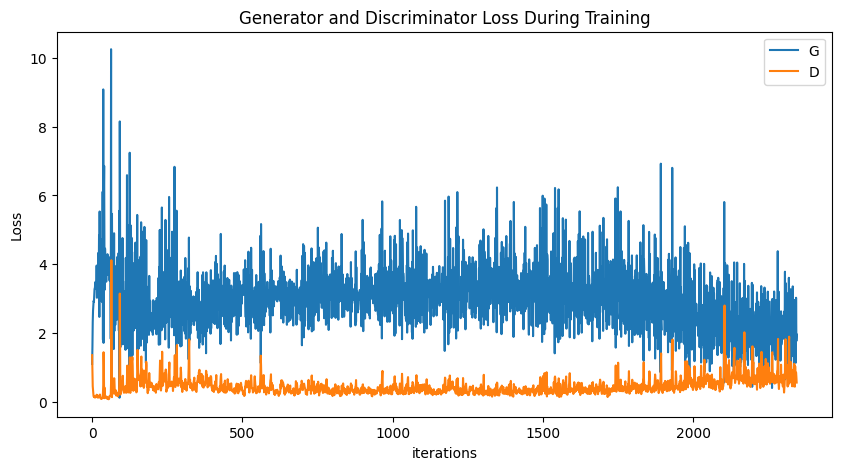

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("./res/gan_res/cgan_losses.png")
plt.show()


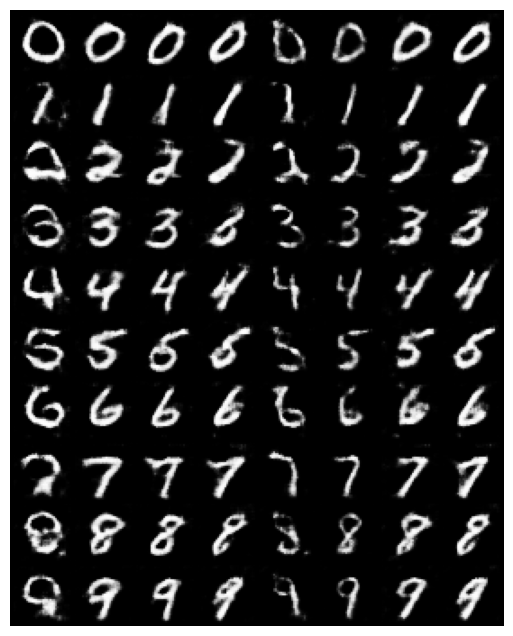

In [14]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())